## Jalgratta tuvastamise mudel

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "data/jalgrattad/"
sz=224

In [4]:
torch.cuda.is_available() & torch.backends.cudnn.enabled

True

## Treeningandmed

Esialgseteks treeningandmeteks on jalgrataste pildid, kokku 30tk kolmes kategoorias:  
Linnaratas (10)  
Maastikuratas (10)  
Maanteeratas (10)

Mudeli valideerimiseks on vastavalt eraldatud andmed:  
Linnaratas (5)  
Maastikuratas (5)  
Maanteeratas (5)

In [5]:
os.listdir(f'{PATH}valid')

['maastikuratas', 'linnaratas', 'maanteeratas']

In [6]:
files = os.listdir(f'{PATH}valid/linnaratas')[:]
files

['6.jpg', '7.jpg', '8.jpg', '5.jpg', '9.jpg']

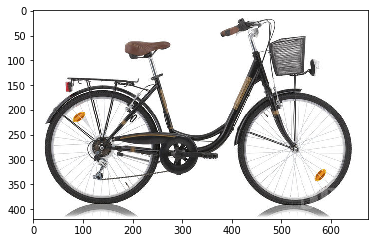

In [7]:
img = plt.imread(f'{PATH}valid/linnaratas/{files[3]}')
plt.imshow(img);

Treeningandmete formaat:

In [8]:
img.shape

(420, 675, 3)

## Siirdeõpe - Esialgne mudel

Esimese katsena võtame valmis mudeli, mis on eeltreenitud ImageNet andmekogu peal (1.2 miljonit pilti 1000 kategoorias).  
Mudel on konvolutsiooniline võrk, <b>resnet34</b>.

<img src="https://justttry.github.io/images/resnet34.png" width="15%">


In [9]:
resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (b

In [10]:
# Uncomment the below if you need to reset your precomputed activations
shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [11]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 8/8 [00:00<00:00, 38.64it/s]


In [12]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

## Mudeli täiendamine

### Data augmentation - andmete rikastamine

Mudelit kauem treenides hakkab mudel ülesobitama, kuna õpib ära tundma just neid kindlaid pilte. Selleks, et mudel pigem edukalt üldistaks ja ei keskenduks kindlatele piltidele kasutame andmete rikastamist. Selleks pöörame ja peegeldame pilti, suurendame, lisame "soola" jne.

#### Vaatame treeningandmeid

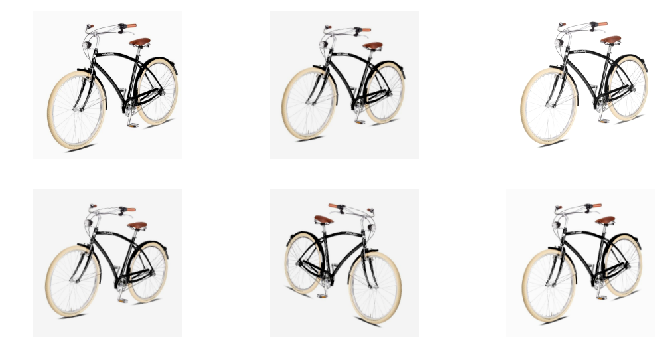

In [13]:
def get_augs():
    tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

In [14]:
bs=10

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, num_workers=1,test_name='test')
    
    return data

In [16]:
data = get_data(sz, bs)

In [17]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 1/1 [00:00<00:00,  8.91it/s]


In [18]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy       
    0      1.209931   1.384652   0.333333  
    1      0.875615   0.992409   0.333333        
    2      0.649804   0.634848   0.666667        



[array([0.63485]), 0.6666666865348816]

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [19]:
learn.precompute=False

In [20]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                
    0      0.226459   0.511423   0.933333  
    1      0.247064   0.45565    0.933333                
    2      0.230045   0.421935   0.933333                



[array([0.42193]), 0.9333333174387614]

### Stochastic gradient descent with restarts (SGDR) - stohhastiline gradientlaskumine

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

`cycle_len` - mitme epohhi järel õpisammu algväärtus taastatakse.  
`fit()` teine parameeter ütleb mitu kordust läbitakse, lõplik protsess näeb seega välja järgmine:

In [21]:
learn.save('224_lastlayer')

In [22]:
learn.load('224_lastlayer')

### Tuunimine

Esialgu õpetasime ainult viimaseid kihte, et nende kaalud vastaksid rohkem meie piltidele. Nüüd avame aga treenimiseks kogu mudeli, et treenida ka esimese osa kaalusid.

In [23]:
learn.unfreeze()

Mudeli esimesed kihid on juba varem treenitud Imagenet piltide peal ja me ei taha neid rikkuda.

Viimased kihid on algselt aga juhuarvudega täidetud.

Selleks, et esimesed kihid vähem mõjutatud oleks kasutame mitmetasemelist õpisammu. Esimeste kihtide õpisamm kõige väiksem, kuna neid ei ole vaja eriti muuta,keskmiste kihtide õpisamm vahepealne ja viimaste kihtide õpisamm suurem (need kihid tunnetavad otseselt meie piltide peal olevaid objekte ja vajavad seega treenimist.

In [24]:
lr=np.array([1e-4,1e-3,1e-2])

In [25]:
learn.fit(lr, 3, cycle_len=3, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy               
    0      1.021298   0.512173   0.733333  
    1      0.880129   0.7889     0.6                     
    2      0.722224   0.709409   0.6                     
    3      0.622167   0.719581   0.666667                
    4      0.501351   0.646311   0.666667                
    5      0.427683   0.527333   0.8                     
    6      0.368563   0.400334   0.8                     
    7      0.333715   0.355626   0.8                     
    8      0.293996   0.320107   0.866667                
    9      0.281362   0.207613   0.933333                
    10     0.249464   0.146612   0.933333                
    11     0.22234    0.097857   0.933333                
    12     0.201825   0.0951     1.0                     
    13     0.182228   0.087751   1.0                     
    14     0.16997    0.084642   1.0                     
    15     0.157236   0.094857   1.0                     
    16     0.145877   0.09010

[array([0.09061]), 1.0]

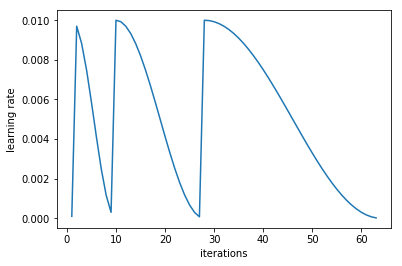

In [26]:
learn.sched.plot_lr()

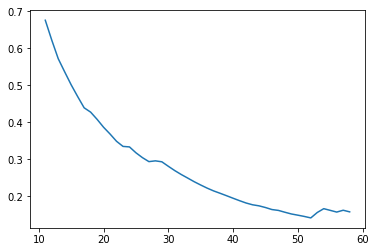

In [27]:
learn.sched.plot_loss()

In [28]:
learn.save('224_all')

In [29]:
learn.load('224_all')

In [30]:
learn.set_data(get_data(299, bs))

In [31]:
learn.fit(lr/10, 2, cycle_len=2, cycle_mult=4)

epoch      trn_loss   val_loss   accuracy                
    0      0.195568   0.276769   0.866667  
    1      0.13431    0.258094   0.866667                
    2      0.141461   0.235429   0.866667                
    3      0.152118   0.210816   0.866667                
    4      0.136203   0.216328   0.866667                
    5      0.113082   0.21623    0.866667                
    6      0.099048   0.199425   0.866667                
    7      0.096493   0.186056   0.933333                 
    8      0.094805   0.186098   0.933333                 
    9      0.104877   0.176599   0.933333                 



[array([0.1766]), 0.9333333174387614]

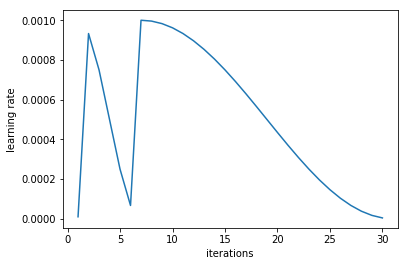

In [32]:
learn.sched.plot_lr()

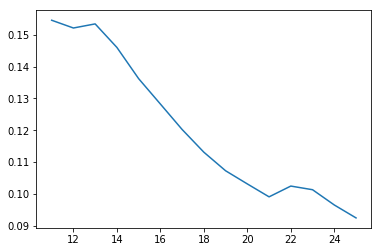

In [33]:
learn.sched.plot_loss()

Andmete rikastamist saab edukalt kasutada ka testimise faasis. TTA - Test time augmentation.

TTA teeb ennustuse pildi kohta, aga ühtlasi ka mitme teise pildi kohta mis on loodud läbi andmete rikastamise (üldjuhul originaal + 4 muudetud versiooni). Seejärel võtab keskmise tulemuse ja kasutab seda.

In [34]:
log_preds,y = learn.TTA(n_aug=4)
probs = np.mean(np.exp(log_preds),0)

In [35]:
accuracy_np(probs, y)

1.0

## Tulemused

### Confusion matrix 

In [36]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

Confusion matrix - aitab analüüsida mudeli tulemusi

[[5 0 0]
 [0 5 0]
 [0 0 5]]


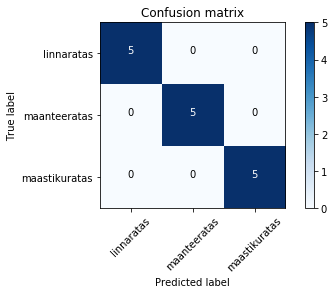

In [38]:
plot_confusion_matrix(cm, data.classes)

In [39]:
preds

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [40]:
y

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

In [41]:
files = os.listdir(f'{PATH}valid/maanteeratas')[:]
files

['6.jpg', '7.jpg', '8.jpg', '5.jpg', '9.jpg']

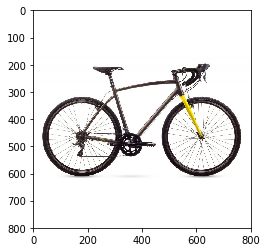

In [42]:
img = plt.imread(f'{PATH}valid/maanteeratas/{files[4]}')
plt.imshow(img);